# LLM's Perception of Hedging Words

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import openai
import os
import re

## Human Survey

In [14]:
prob_words = pd.read_csv("https://raw.githubusercontent.com/wadefagen/datasets/master/Perception-of-Probability-Words/survey-results.csv")

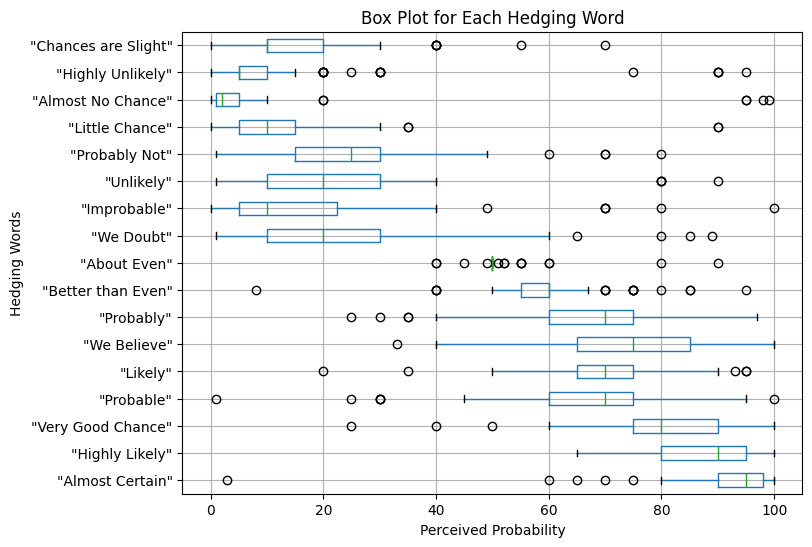

In [15]:
prob_words.boxplot(vert=False, figsize=(8,6))
plt.title('Box Plot for Each Hedging Word')
plt.ylabel('Hedging Words')
plt.xlabel('Perceived Probability')
plt.grid(True)
plt.show()

## Recreate the Experiment with LLMs

For experiment implementation details, refer to https://arxiv.org/abs/2407.15814.

In [ ]:
# adjust the above hedging words to fit into the following sentence structure grammatically correctly: 
# [name] believes [survey hedging phrase] that [statement].

survey_hedging_phrase = [
    "that the chances are slight",
    "it is highly unlikely",
    "there is almost no chance",
    # to be completed ...
]

In [16]:
hedging_words = [
    "almost certain", "highly likely", "very likely", "probable",
    "somewhat likely", "possible", "uncertain", "somewhat unlikely",
    "unlikely", "not likely", "doubtful", "very unlikely", "highly unlikely"
]

In [17]:
female_names = ["Amanda", "Bonnie", "Camille", "Catherine", "Cheri", "Ethel", "Gabriela", "Jacquelyn", "Jessica", "Laura", "Olga", "Roxanne", "Silvia", "Tara", "Violet"]
male_names = ["Brendan", "Bruce", "David", "Gary", "Isaac", "Jeffery", "Joey", "Johnnie", "Kenny", "Lance", "Marco", "Mike", "Nathan", "Nick", "Raul"]

In [18]:
statements = [
    "they will buy a new watch this Thanksgiving weekend.",
    "they will be offered a promotion this fall.",
    "the company will have another round of layoffs by mid-July.",
    "there will be vegetarian options at the barbecue.",
    "they will visit New York over winter break.",
    "the restaurant near their apartment accepts reservations.",
    "the new museum is offering complimentary admission.",
    "there is a yoga studio within 2 miles of their workplace.",
    "there are more than eighty students in the auditorium right now.",
    "the temperature in the office is at least 72 degrees Fahrenheit.",
    "their boss owns a blue car.",
    "their friend has a leather jacket.",
    "their cousin has a vegetable garden.",
    "their classmate owns a guitar.",
    "their boss has a stereo amplifier.",
    "their cousin prefers spinach over broccoli.",
    "their boss prefers coffee over tea.",
    "their friend prefers running over cycling.",
    "their neighbor prefers the beach over the mountains.",
    "their coworker prefers reading books over watching movies."
]

In [19]:
all_sentences = {}

for hedge in hedging_words:
    for name in female_names + male_names:
        for statement in statements:
            all_sentences[f"""{name} believes it is {hedge} that {statement}"""] = hedge

In [20]:
list(all_sentences.keys())[1]

'Amanda believes it is almost certain that they will be offered a promotion this fall.'

In [ ]:
# Need to implement: keep retrying after rate limit errors!!! Or else the code will stop!!!
client = openai.OpenAI(api_key=os.environ["TOGETHER_API_KEY"], base_url="https://api.together.xyz/v1")
def sample(prompt, model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"):
    response = client.chat.completions.create(
        model=model,
        temperature=0,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content.strip()

In [22]:
def get_query_template(sentence):
    return f"""{sentence} From their perspective, considering the use of hedging words, what is the probability (from 0 to 100) that the statement is true? Concisely provide your response only in the following format: Probability: [0-100]%"""

In [23]:
probability_map = {h : []  for h in hedging_words}
probability_map

{'almost certain': [],
 'highly likely': [],
 'very likely': [],
 'probable': [],
 'somewhat likely': [],
 'possible': [],
 'uncertain': [],
 'somewhat unlikely': [],
 'unlikely': [],
 'not likely': [],
 'doubtful': [],
 'very unlikely': [],
 'highly unlikely': []}

In [ ]:
# should incorporate parallelism to speed it up
for sentence, hedge in all_sentences.items():
    response = sample(get_query_template(sentence))
    pattern = r"\b(?:Probability|Prob(?:\.|ability)?|P)\s*[:=]?\s*(\d+)%"
    match = re.search(pattern, response, re.IGNORECASE)
    if match:
        probability = int(match.group(1))
        probability_map[hedge].append(probability)
        print(hedge, probability)

## Plot our results/findings